# Oct 14, 2021 meeting. Request for SW precip plots for CPC/CAM6/CCM3
1. area average (ocean to 105W and 30N-45N) precip changes in mm/day and percentage of total. 
   3 month running average from 1979-2021
2. box and whiskers for 4 most recent seasons (as in Jennie's plots). Plot model ensemble members, ensemble mean and obs
3. How anomalous was this year compared to past? Try do the same for models, including each ensemble member separately.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

In [2]:
%run ingrid_colorbars.py

In [3]:
def fix_grids(ds,domain,time_start,times):
    if 'X' in ds.coords:
        ds = ds.rename({'Y':'lat','X':'lon'})
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'P' in ds.coords:
        ds = ds.rename({'P':'plev'})
        
    ds = ds.sortby('lat').sel(lat=slice(domain[2],domain[3]))
    ds.coords['lon'] = (ds.coords['lon'] - domain[0]) % 360 +  domain[0] ; ds = ds.sortby('lon')
    ds = ds.sel(lon=slice(domain[0],domain[1]))
    ds['time'] = pd.date_range(time_start,periods=len(ds.time), freq='MS').shift(15,freq='D')
    ds = ds.sel(time=slice(times[0],times[1]))
    return ds

def load_model(domain,time_start,times,prefix,varlist):
    filelist = [f'{prefix}/{var}.nc' for var in varlist]
    ds = xr.open_mfdataset(filelist,decode_times=False)
    return fix_grids(ds,domain,time_start,times)

def get_data(gtype,domain,time_range):
    if gtype == 'NOAA':
        prefix = 'http://iridl.ldeo.columbia.edu'
        if not os.path.exists('NOAA_rain.nc'):    
            data   = '/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/'
            url = f'{prefix}{data}.RETRO/.rain/{data}.REALTIME/.rain/appendstream/monthlyAverage/data.nc'
            os.system(f'wget {url}; mv data.nc NOAA_rain.nc')
        dsn = xr.open_dataset('NOAA_rain.nc',decode_times=False)
        dst = fix_grids(dsn,domain,'1979-01',time_range)
       
    # UCAR - CAM6 - ERSSTv5 - 0.9 x 1.25
    if gtype == 'UCAR':
        prefix_sl = '/net/hodges/d2/naomi/ingrid/UCAR/ERSSTv5/goga/single_level/mean/'
        prefix_pl = '/net/hodges/d2/naomi/ingrid/UCAR/ERSSTv5/goga/pressure_level/mean/from_1950/'
        varlist=['PRECC', 'PRECL','OCNFRAC', 'ICEFRAC']

        dst = load_model(domain,'1880-01',time_range,prefix_sl,varlist).sel(time=slice('1950-01','2021-01'))
        prtot = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = prtot.where(dst.OCNFRAC<1.0).where(dst.ICEFRAC==0.0)
        dst = dst.drop(['PRECC','PRECL','OCNFRAC','ICEFRAC'])
    # LDEO - CCM3 - HadISST - T42 ( 2.8 x 2.8)
    if gtype == 'CCM3':
        time_start = '1856-01'
        prefix = '/home/naomi/PROJECTS/CCM3/goga/atm-mean/'
        varlist=['SLD/ORO', 'SLD/PRECC', 'SLD/PRECL']

        dst = load_model(domain,time_start,time_range,prefix,varlist)
        prtot = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = prtot.where(dst.ORO==1.0)
        dst = dst.drop(['PRECC','PRECL','ORO'])
    # LDEO - GOGA - HadOIBlend - 1.9 x 2.5
    if gtype == 'CAM6':
        time_start = '1979-01'
        prefix = '/net/hodges/d3/pma2107/forRichard/CAM6/runs/ensemble-extension-fixed/atm/mean/'
        varlist=['SLD/OCNFRAC', 'SLD/ICEFRAC', 'SLD/PRECC', 'SLD/PRECL']

        dst = load_model(domain,time_start,time_range,prefix,varlist)
        prtot = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] =prtot.where(dst.OCNFRAC<1.0).where(dst.ICEFRAC==0.0)
        dst = dst.drop(['PRECC','PRECL','OCNFRAC','ICEFRAC'])
    return dst

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


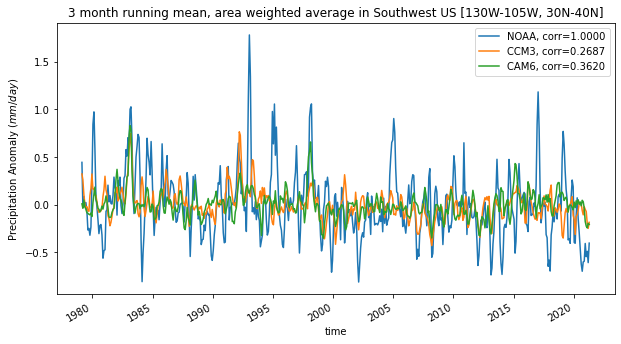

In [7]:
# Precip anomaly in mm/day
domain = [232, 255, 30, 40]
time_range = ['1979-01','2021-05'] 
running = 3
#dtypes = ['NOAA','CCM3','CAM6','UCAR']
dtypes = ['NOAA','CCM3','CAM6']

fig = plt.figure(figsize=(10,5))
TS = {}
for dtype in dtypes: 
    ds = get_data(dtype,domain,time_range).rolling(time=running, center=True).mean()
    #ds = get_data(dtype,domain,time_range).coarsen(time=running, boundary='trim').mean()
    ds_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))
    weights = np.cos(np.deg2rad(ds.lat))
    TS[dtype] = ds_anom.rain.weighted(weights).mean(['lon', 'lat'])
    #TS[dtype].plot(label=dtype)
    
for dtype in dtypes: 
    corr = xr.corr(TS['NOAA'],TS[dtype],'time').values
    c2 = "{:.4f}".format(corr)
    TS[dtype].plot(label=f'{dtype}, corr={c2}')

plt.legend()
plt.ylabel(r'Precipitation Anomaly ($mm/day$)')
plt.title(f'{running} month running mean, area weighted average in Southwest US [130W-105W, {domain[2]}N-{domain[3]}N]');
plt.savefig(f'TS-pr_anom-{running}mrm_{domain[2]}N-{domain[3]}N.eps');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


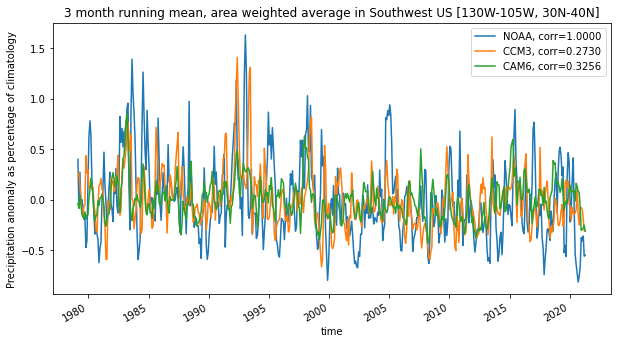

In [8]:
# Precip anomaly as percentage of climatology
domain = [232, 255, 30, 40]
time_range = ['1979-01','2021-05'] 
running = 3
#dtypes = ['NOAA','CCM3','CAM6','UCAR']
dtypes = ['NOAA','CCM3','CAM6']

fig = plt.figure(figsize=(10,5))
TS = {}
for dtype in dtypes: 
    ds = get_data(dtype,domain,time_range).rolling(time=running, center=True).mean()
    ds_clim = ds.groupby('time.month').mean('time')
    ds_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))
    da_percent = ds_anom.rain.groupby('time.month') / ds_clim.rain
    weights = np.cos(np.deg2rad(ds.lat))
    TS[dtype] = da_percent.weighted(weights).mean(['lon', 'lat'])
    
for dtype in dtypes: 
    corr = xr.corr(TS['NOAA'],TS[dtype],'time').values
    c2 = "{:.4f}".format(corr)
    TS[dtype].plot(label=f'{dtype}, corr={c2}')

plt.legend()
plt.ylabel(r'Precipitation anomaly as percentage of climatology')
plt.title(f'{running} month running mean, area weighted average in Southwest US [130W-105W, {domain[2]}N-{domain[3]}N]');
plt.savefig(f'TS-pr_percent-{running}mrm_{domain[2]}N-{domain[3]}N.eps');

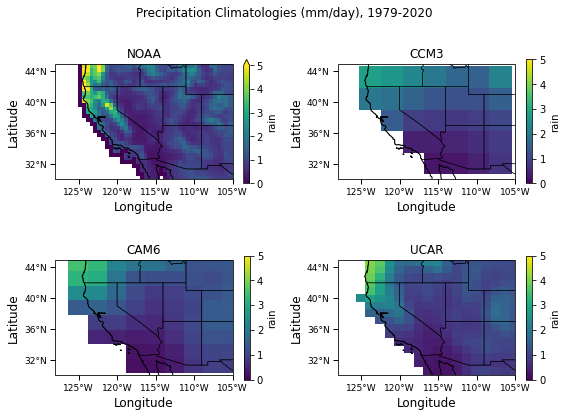

In [6]:
domain = [232, 255, 30, 45]
time_range = ['1979-01','2020-12'] 

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=(domain[1]+domain[0])/2)},
                        figsize=(8,6))
axs=axs.flatten()
for i,dtype in enumerate(['NOAA','CCM3','CAM6','UCAR']):  
    ds = get_data(dtype,domain,time_range)
    ds_clim = ds.groupby('time.month').mean('time')
    axs[i].set_extent(domain, crs=ccrs.PlateCarree())
    im=ds_clim.rain.mean('month').plot(ax=axs[i],transform = ccrs.PlateCarree(),vmin=0,vmax=5,rasterized=True,cbar_kwargs={'shrink': 0.70})
    axs[i].add_feature(cfeature.COASTLINE, linewidth=1.0)
    axs[i].add_feature(cfeature.BORDERS, linewidth=0.5)
    axs[i].add_feature(cfeature.STATES, linewidth=0.5)
    axs[i].title.set_text(dtype)
    axs[i].set_ylabel('lat')
    # Label x-axis and make tick labels
    axs[i].xaxis.set_label_text('Longitude',fontsize=12)
    axs[i].set_xticks(np.arange(domain[0]+3,domain[1]+3,5), crs=ccrs.PlateCarree())
    axs[i].xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter())
    #axs[i].xaxis.set_minor_locator(MultipleLocator(10))

    # Label y-axis and make tick labels
    axs[i].yaxis.set_label_text('Latitude',fontsize=12)
    axs[i].set_yticks(np.arange(domain[2]+2,domain[3],4), crs=ccrs.PlateCarree())
    axs[i].yaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter())
    #axs[i].yaxis.set_minor_locator(MultipleLocator(10))

    # Make tick marks
    axs[i].tick_params(which='major', width=1.00, length=5, labelsize=9)
    axs[i].tick_params(which='minor', width=0.75, length=2.5)
    
fig.suptitle('Precipitation Climatologies (mm/day), 1979-2020')     
plt.tight_layout()
plt.savefig(f'PR_climo.eps');